Adaptacion de modelo tomado de https://apmonitor.com/dde/index.php/Main/LLMTransformers con datos de Shanghai. Version 2

Modificacion: Se normalizaron los datos manualmente con pytorch

In [1]:
#Veamos si la grafica esta disponible
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 2060 SUPER


In [2]:
# Configurar el dispositivo GPU para utilizarlo en lugar del CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [3]:
#Carguemos los datos
import pandas as pd
ShanghaiDat=pd.read_csv('Shanghai-2005-2025.csv')
ShanghaiDat=ShanghaiDat.drop(ShanghaiDat.columns[0], axis=1)

In [4]:
#Debemos convertir nuestros datos en una ventana de datos deslizantes.
import numpy as np

# Convertimos los datos a un array de 1 dimension
ShanghaiDat = np.array(ShanghaiDat).flatten()
#Probemos normalizar los datos
ShanghaiDat = torch.tensor(ShanghaiDat, dtype=torch.float32)
mean = ShanghaiDat.mean()
std = ShanghaiDat.std()
ShanghaiDat = (ShanghaiDat - mean) / std
ShanghaiDat = ShanghaiDat.numpy() 


#Dividimos en epocas de 10 dias
def Epocas(sequence_length=12):
    size = len(ShanghaiDat) 
    sequences = [ShanghaiDat[i:i+sequence_length] for i in range(size-sequence_length)]
    next_points = ShanghaiDat[sequence_length:]

    # Convertir a NumPy arrays correctamente
    return np.array(sequences), np.array(next_points)

In [5]:
#Terminamos de cargar todas las librerias que vamos a usar
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, next_points):
        self.sequences = sequences
        self.next_points = next_points

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.next_points[idx]

In [6]:
# Transformer Model (simplified for numerical data)
class TransformerModel(nn.Module):
    def __init__(self, input_size=1, sequence_length=12, num_layers=2, num_heads=4, dim_feedforward=512):
        super(TransformerModel, self).__init__() 
        self.sequence_length = sequence_length
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size*sequence_length, nhead=num_heads, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(input_size * sequence_length, 1)

    def forward(self, src):
        src = src.reshape(-1, self.sequence_length, 1) 
        src = src.flatten(start_dim=1) 
        src = src.unsqueeze(0) 
        out = self.transformer_encoder(src) 
        out = out.squeeze(0) 
        return self.fc_out(out) 

In [7]:
# Preparamos los datos
sequences, next_points = Epocas()
dataset = TimeSeriesDataset(sequences, next_points) 
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
#Entrenamiento del modelo
model = TransformerModel().to(device)
criterion = nn.MSELoss() #Funcion de perdida
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #Optimizador

# Training loop
losses=[]
for epoch in range(300):
    for seq, next_point in dataloader:
        seq, next_point = seq.float().to(device), next_point.float().unsqueeze(1).to(device) 
        output = model(seq)
        loss = criterion(output, next_point) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    losses.append(loss)

C:\Users\Antonio Rojas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 0.2534966468811035
Epoch 2, Loss: 0.06930111348628998
Epoch 3, Loss: 0.08617889136075974
Epoch 4, Loss: 0.04487599432468414
Epoch 5, Loss: 0.03408120945096016
Epoch 6, Loss: 0.03373562917113304
Epoch 7, Loss: 0.02263675071299076
Epoch 8, Loss: 0.04142182692885399
Epoch 9, Loss: 0.03861395642161369
Epoch 10, Loss: 0.012829695828258991
Epoch 11, Loss: 0.08381237089633942
Epoch 12, Loss: 0.03505701199173927
Epoch 13, Loss: 0.01781885325908661
Epoch 14, Loss: 0.013892482966184616
Epoch 15, Loss: 0.06848514080047607
Epoch 16, Loss: 0.018893830478191376
Epoch 17, Loss: 0.016971025615930557
Epoch 18, Loss: 0.015487556345760822
Epoch 19, Loss: 0.017978563904762268
Epoch 20, Loss: 0.010841920040547848
Epoch 21, Loss: 0.0203698743134737
Epoch 22, Loss: 0.02788841724395752
Epoch 23, Loss: 0.01619667001068592
Epoch 24, Loss: 0.02614595741033554
Epoch 25, Loss: 0.03303803876042366
Epoch 26, Loss: 0.01928228884935379
Epoch 27, Loss: 0.05208694189786911
Epoch 28, Loss: 0.03317182883620

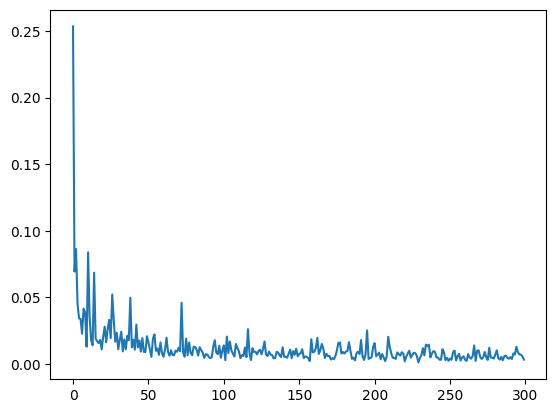

In [9]:
import matplotlib.pyplot as plt

losses = [loss.detach().cpu().item() for loss in losses]
losses = np.array(losses)

plt.plot(losses)
plt.show()

In [52]:
test_seq = torch.tensor(sequences[0]).float()
test_seq = (test_seq - mean) / std #Normalizamos usando mean y std calculados al entrenar
test_seq = test_seq.unsqueeze(0).to(device)

#Hacemos la prediccion
with torch.no_grad():
    predicted_point = model(test_seq)

predicted_value = (predicted_point.item() * std) + mean #Desnormalizamos la predicción para interpretarla
real_value = (next_points[0] * std) + mean #También desnormalizamos el valor real para compararlo correctamente

print("Predicción (dato siguiente):", predicted_value)
print("Dato siguiente real:", real_value)


Predicción (dato siguiente): tensor(1005.2520)
Dato siguiente real: tensor(1204.3940)


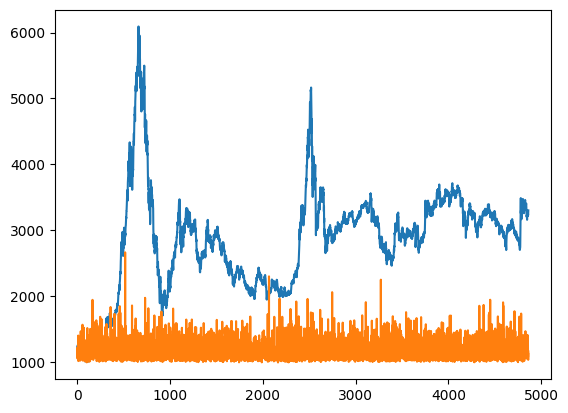

[1063.8197021484375, 1225.386962890625, 1067.6800537109375, 1190.816650390625, 1151.17919921875, 1118.445556640625, 1194.196044921875, 1198.40478515625, 1151.2513427734375, 1405.4517822265625, 1110.3853759765625, 1018.9129638671875, 1149.239990234375, 1025.22509765625, 1182.8377685546875, 1216.2926025390625, 1108.051513671875, 1284.0533447265625, 1038.89892578125, 1098.393798828125, 1164.345947265625, 1068.9271240234375, 1082.7274169921875, 1280.522216796875, 1137.353271484375, 1102.252685546875, 1045.57080078125, 1154.750244140625, 1076.6595458984375, 1069.9320068359375, 1050.280517578125, 1026.0050048828125, 1161.0462646484375, 1046.7850341796875, 1123.32666015625, 1395.04345703125, 1470.293212890625, 1107.7159423828125, 1060.8323974609375, 1136.4111328125, 1254.554931640625, 1383.7197265625, 1100.500244140625, 1106.3690185546875, 1067.099853515625, 1091.5968017578125, 1102.6983642578125, 1276.4989013671875, 1069.098876953125, 1131.2188720703125, 1291.7442626953125, 1072.808471679687

In [60]:
#Comparemos los datos reales con las predicciones que hace el modelo con los mismos
predicciones=[]
for i in sequences:
    test_seq = torch.tensor(i).float()
    test_seq = (test_seq - mean) / std
    test_seq = test_seq.unsqueeze(0).to(device)
    with torch.no_grad():
        predicted_point = model(test_seq)
    predicted_value = (predicted_point.item() * std) + mean
    predicciones.append(predicted_value.item())

valores_reales=[]
for i in next_points:
    real_value = (i * std) + mean
    valores_reales.append(real_value.item())


plt.plot(valores_reales)
plt.plot(predicciones)
plt.show()
print(predicciones)
print(valores_reales)

